In [1]:
# We want to load all experiments together into one big dataframe of this shape:
# [ "gsm8k" : ["Llama-3.1-8B-Instruct" : { <experiment_data> },
#               "Qwen-3" : { <experiment_data> }],
#    "creative_writing" : ["Llama-3.1-8B-Instruct" : { <experiment_data> }, 
#                           "Qwen-3" : { <experiment_data> }]
# ]

# And each experiment_data has this shape:
# [ "prompt0" : { <prompt_data> },
#    "prompt1" : { <prompt_data> }
# ]

# And each prompt_data has this shape:
# {
#  "top_p_tokens" : [ <list of lists of top p token ids> ],
#  "top_p_probs"  : [ <list of lists of top p token probabilities (after softmax)> ],
#  "top_p_logits" : [ <list of lists of top p token logits (before softmax)> ],
#  "top_p_generated_tokens" : [ <list of lists of top p tokens decoded> ],
#  "top_p_entropies" : [ <list of entropies of top p tokens> ],
#  "full_entropies"  : [ <list of entropies over full distribution> ],
#   "prompt" : "<prompt that was used>",
#  "correct" : "<did the model answer correct (for math questions)"
# }
# We nedd top_p_tokens
# We dont need top_p_probs (they can be calculated from top_p_logits via softmax)
# We dont need top_p_logits (because we dont look at those for now)
# We dont need top_p_generated_tokens (they can be decoded from top_p_tokens)
# we dont need top_p_entropies (we want to explore full entropy!)
# We need full_entropies, because we cant save all 32k logits to calculate it later.
# we need prompt
# we dont need correct (for now we dont care about that)

#dict_keys(['top_p_tokens', 'top_p_probs', 'top_p_logits', 'generated_tokens', 'entropies', 'cosines', 'prompt', 'correct'])

In [2]:
# Dict[str, Dict[str, List[Dict[str, Tensor]]]]
# dataset_name -> model_name -> list of entries

import os
import torch

# Final structure:
# Dict[str, Dict[str, Dict[str, Any]]]
# results[dataset_name][model_name] = {
#     "file_contents": <string from txt file>,
#     "data": <list of dicts with tensors from .pt>
# }

import numpy as np

def load_results(results_root="results"):
    '''
    Go through results/ and create a dict for each dataset-model combination, save them in a model_name-indexed dict for each dataset,
    and save those in a dataset_name-indexed dict. Each inner dict contains the data read from the .pt file in that directory.
    returns said dict.
    '''
    results = {}

    for dataset_name in os.listdir(results_root):
        dataset_path = os.path.join(results_root, dataset_name)
        if not os.path.isdir(dataset_path):
            continue

        results[dataset_name] = {}

        for model_name in os.listdir(dataset_path):
            model_path = os.path.join(dataset_path, model_name)
            if not os.path.isdir(model_path):
                continue

            pt_files = [f for f in os.listdir(model_path) if f.endswith(".pt")]
            txt_files = [f for f in os.listdir(model_path) if f.endswith(".txt")]

            if not pt_files:
                continue
            if len(pt_files) > 1:
                raise ValueError(f"Multiple .pt files in {model_path}, expected only one.")
            if len(txt_files) != 1:
                raise ValueError(f"Expected exactly one .txt file in {model_path}, found {len(txt_files)}.")

            pt_path = os.path.join(model_path, pt_files[0])
            txt_path = os.path.join(model_path, txt_files[0])
            print(pt_path)
            data = torch.load(pt_path)
            with open(txt_path, "r") as f:
                file_contents = f.read()

            results[dataset_name][model_name] = {
                "hf_model_name": file_contents,
                "data": data
            }

    return results


In [3]:
# The reason we have to precompute the cosines during training is that 
# we need the model embedding layer to produce the vector embeddings. 
# The tokenizer doesnt have that, only the model

import matplotlib.pyplot as plt
import numpy as np

def process_experiment_results(experiment_results, remove_zero_one_points):
    '''
    Do the correlation analysis for one model-dataset combination.
    Compute pearson and spearman correlation scores.
    Create plot with median cosines and standard deviation
    '''
    entropies = []
    cosines = []

    for prompt_result in experiment_results["data"]:
        prompt_entropies = prompt_result["entropies"]
        prompt_cosines = prompt_result["cosines"]
        entropies.extend(prompt_entropies)
        cosines.extend(prompt_cosines)
    
    entropies = np.array(entropies, dtype=float)
    cosines = np.array(cosines, dtype=float)

    #mask = (entropies == 0) & np.isnan(cosines)
    #cosines[mask] = 1.0

    
    if remove_zero_one_points:
        mask = ~((entropies == 0) & (cosines == 1))
        entropies = entropies[mask]
        cosines = cosines[mask]

    # compute pearson and spearman
    from scipy.stats import pearsonr
    r, p = pearsonr(entropies, cosines)
    print("pearson coefficient")
    print(r)
    print(p)
    from scipy.stats import spearmanr
    rho, p = spearmanr(entropies, cosines)
    print("Spearman coefficient")
    print(rho)
    print(p)


    #coeffs = np.polyfit(entropies, cosines, deg=4)
    #print(coeffs)
    # Generate x values from 0 to 1
    #x_fit = np.linspace(0, 8, 500)

    # Compute the polynomial values
    #y_fit = np.polyval(coeffs, x_fit)

    # Plot
    #plt.figure(figsize=(8, 5))
    #plt.plot(x_fit, y_fit, label='Cubic Polynomial Fit', color='darkred')
    #plt.xlabel("Normalized X")
    #plt.ylabel("Predicted Y")
    #plt.title("Cubic Polynomial Regression Fit")
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()


    # Create scatter plot
    #plt.figure(figsize=(8, 6))
    #plt.scatter(entropies, cosines, alpha=0.1)
    #plt.xlabel('Entropy')
    #plt.ylabel('Cosine Similarity')
    #plt.title('Entropy vs. Cosine Similarity')
    #plt.tight_layout()
    #plt.show()
    # Create line plot

    from scipy.stats import binned_statistic

    # Assuming entropies and cosines are already numpy arrays
    num_bins = 50
    bin_means, bin_edges, _ = binned_statistic(entropies, cosines, statistic='mean', bins=num_bins)
    bin_medians, _, _ = binned_statistic(entropies, cosines, statistic='median', bins=num_bins)

    # Compute standard deviation per bin
    bin_indices = np.digitize(entropies, bin_edges)
    bin_std = np.zeros(num_bins)
    for i in range(1, num_bins + 1):
        bin_values = cosines[bin_indices == i]
        if len(bin_values) > 0:
            bin_std[i-1] = np.std(bin_values)

    # Bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, bin_medians, label='Median Cosine Similarity', color='blue')
    plt.fill_between(bin_centers,
                    bin_medians - bin_std,
                    bin_medians + bin_std,
                    color='blue',
                    alpha=0.2,
                    label='±1 Std Dev')
    plt.xlabel('Entropy')
    plt.ylabel('Cosine Similarity')
    plt.title('Entropy vs. Cosine Similarity (Median ± Std Dev)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    


In [4]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def unimodal_fitting(entropies, cosines):
    # Example input (replace with your actual data)
    X = np.array(entropies)
    y = np.array(cosines)

    # Define the unimodal function
    def unimodal_func(x, a, b, c):
        return a * x * np.exp(-b * x) + c

    # Fit the curve
    popt, _ = curve_fit(unimodal_func, X, y, maxfev=10000)
    y_pred = unimodal_func(X, *popt)
    r2 = r2_score(y, y_pred)
    print(f"Fitted params: a={popt[0]:.4f}, b={popt[1]:.4f}, c={popt[2]:.4f}")
    print(f"R² = {r2:.3f}")

    # Sort for plotting
    sort_idx = np.argsort(X)
    X_sorted = X[sort_idx]
    y_pred_sorted = y_pred[sort_idx]

    # Plot data and fit
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(X, y, alpha=0.3, label='Data')
    ax.plot(X_sorted, y_pred_sorted, color='red', label='Unimodal Fit')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title('Unimodal Fit: $a x e^{-bx} + c$')
    ax.legend()
    fig.tight_layout()
    fig.show()

In [5]:
root_dir = "results/"
results = load_results()
for dataset_name in os.listdir(root_dir):
    dataset_path = os.path.join(root_dir, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    for model_name in os.listdir(dataset_path):
        model_path = os.path.join(dataset_path, model_name)
        if not os.path.isdir(model_path):
            continue

        print(f"Dataset: {dataset_name} Model: {model_name}")
        experiment_results = results[dataset_name][model_name]
        process_experiment_results(experiment_results, True)


        #TODO vlt der grund warum es wenn entropy ~0 ist, die cosine runtergeht, ist weil dann es nur ein passendes token gibt mit hoher Wkt
        # und das zweitbeste token ist sehr unsimilar aber hat dafür eine kleine Wkt. 

        #TODO spearman misst monotonie, pearson misst linear (in etwa)
        # Da spearman stärker ist bei uns, kann es zeigen dass es monoton beziehung ist, die aber nicht perfekt linear ist

FileNotFoundError: [Errno 2] No such file or directory: 'results'

./../results/correlation_exp/writingprompts/Llama-3.1-8B/output_writing_llamabase.pt
./../results/correlation_exp/writingprompts/Mistral-7B-v0.1/output_writing_mistral.pt
./../results/correlation_exp/writingprompts/Llama-3.1-8B-Instruct/output_writing_llamainstruct.pt
./../results/correlation_exp/writingprompts/deepseek-llm-7b-base/output_writing_deepseek.pt
./../results/correlation_exp/writingprompts/Qwen3-8B/output_writing_qwen.pt
./../results/correlation_exp/gsm8k/Llama-3.1-8B/output_gsm8k_llamabase.pt
./../results/correlation_exp/gsm8k/Mistral-7B-v0.1/output_gsm8k_mistral.pt
./../results/correlation_exp/gsm8k/Llama-3.1-8B-Instruct/output_gsm8k_llamainstruct.pt
./../results/correlation_exp/gsm8k/deepseek-llm-7b-base/output_gsm8k_deepseek.pt
./../results/correlation_exp/gsm8k/Qwen3-8B/output_gsm8k_qwen.pt
./../results/correlation_exp/xsum/Llama-3.1-8B/output_xsum_llamabase.pt
./../results/correlation_exp/xsum/Mistral-7B-v0.1/output_xsum_mistral.pt
./../results/correlation_exp/xsum/Ll

/tmp/ipykernel_29456/2613513869.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  model_colors = dict(zip(models, cm.get_cmap("tab10").colors[:len(models)]))
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Model: Mistral-7B-v0.1 Dataset: gsm8k
  Pearson r=-0.503, Spearman rho=-0.667
Fitted params: a=0.3562, b=1.2770, c=0.0400
R² = 0.940
Model: Mistral-7B-v0.1 Dataset: writingprompts
  Pearson r=-0.494, Spearman rho=-0.662
Fitted params: a=0.3630, b=1.2808, c=0.0404
R² = 0.948


/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Model: Mistral-7B-v0.1 Dataset: xsum
  Pearson r=-0.512, Spearman rho=-0.666
Fitted params: a=0.3668, b=1.3171, c=0.0421
R² = 0.953
Model: Qwen3-8B Dataset: gsm8k
  Pearson r=-0.365, Spearman rho=-0.392
Fitted params: a=0.3260, b=1.2612, c=0.0289
R² = 0.914
Model: Qwen3-8B Dataset: writingprompts
  Pearson r=-0.380, Spearman rho=-0.410
Fitted params: a=0.3659, b=1.3307, c=0.0286
R² = 0.879
Model: Qwen3-8B Dataset: xsum
  Pearson r=-0.373, Spearman rho=-0.429
Fitted params: a=0.3335, b=1.3057, c=0.0296
R² = 0.922
Model: Llama-3.1-8B Dataset: gsm8k
  Pearson r=-0.617, Spearman rho=-0.756
Fitted params: a=0.5956, b=1.3554, c=0.0496
R² = 0.855
Model: Llama-3.1-8B Dataset: writingprompts
  Pearson r=-0.615, Spearman rho=-0.752
Fitted params: a=0.5385, b=1.3011, c=0.0504
R² = 0.923
Model: Llama-3.1-8B Dataset: xsum
  Pearson r=-0.625, Spearman rho=-0.757
Fitted params: a=0.5450, b=1.3021, c=0.0514
R² = 0.930
Model: Llama-3.1-8B-Instruct Dataset: gsm8k
  Pearson r=-0.570, Spearman rho=-0.701


/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  Pearson r=-0.425, Spearman rho=-0.648
Fitted params: a=0.3283, b=1.3776, c=0.0313
R² = 0.918
Model: deepseek-llm-7b-base Dataset: writingprompts
  Pearson r=-0.433, Spearman rho=-0.672
Fitted params: a=0.3238, b=1.3363, c=0.0286
R² = 0.873
Model: deepseek-llm-7b-base Dataset: xsum
  Pearson r=-0.449, Spearman rho=-0.666
Fitted params: a=0.3185, b=1.3407, c=0.0292
R² = 0.906


/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_29456/2613513869.py:170: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



=== Correlation Statistics Table ===
                                      Pearson r  Pearson p  Spearman r  Spearman p
Model                 Dataset                                                     
Mistral-7B-v0.1       gsm8k             -0.5026        0.0     -0.6667         0.0
                      writingprompts    -0.4944        0.0     -0.6616         0.0
                      xsum              -0.5121        0.0     -0.6664         0.0
Qwen3-8B              gsm8k             -0.3651        0.0     -0.3922         0.0
                      writingprompts    -0.3803        0.0     -0.4098         0.0
                      xsum              -0.3730        0.0     -0.4287         0.0
Llama-3.1-8B          gsm8k             -0.6167        0.0     -0.7564         0.0
                      writingprompts    -0.6148        0.0     -0.7516         0.0
                      xsum              -0.6252        0.0     -0.7571         0.0
Llama-3.1-8B-Instruct gsm8k             -0.5696  

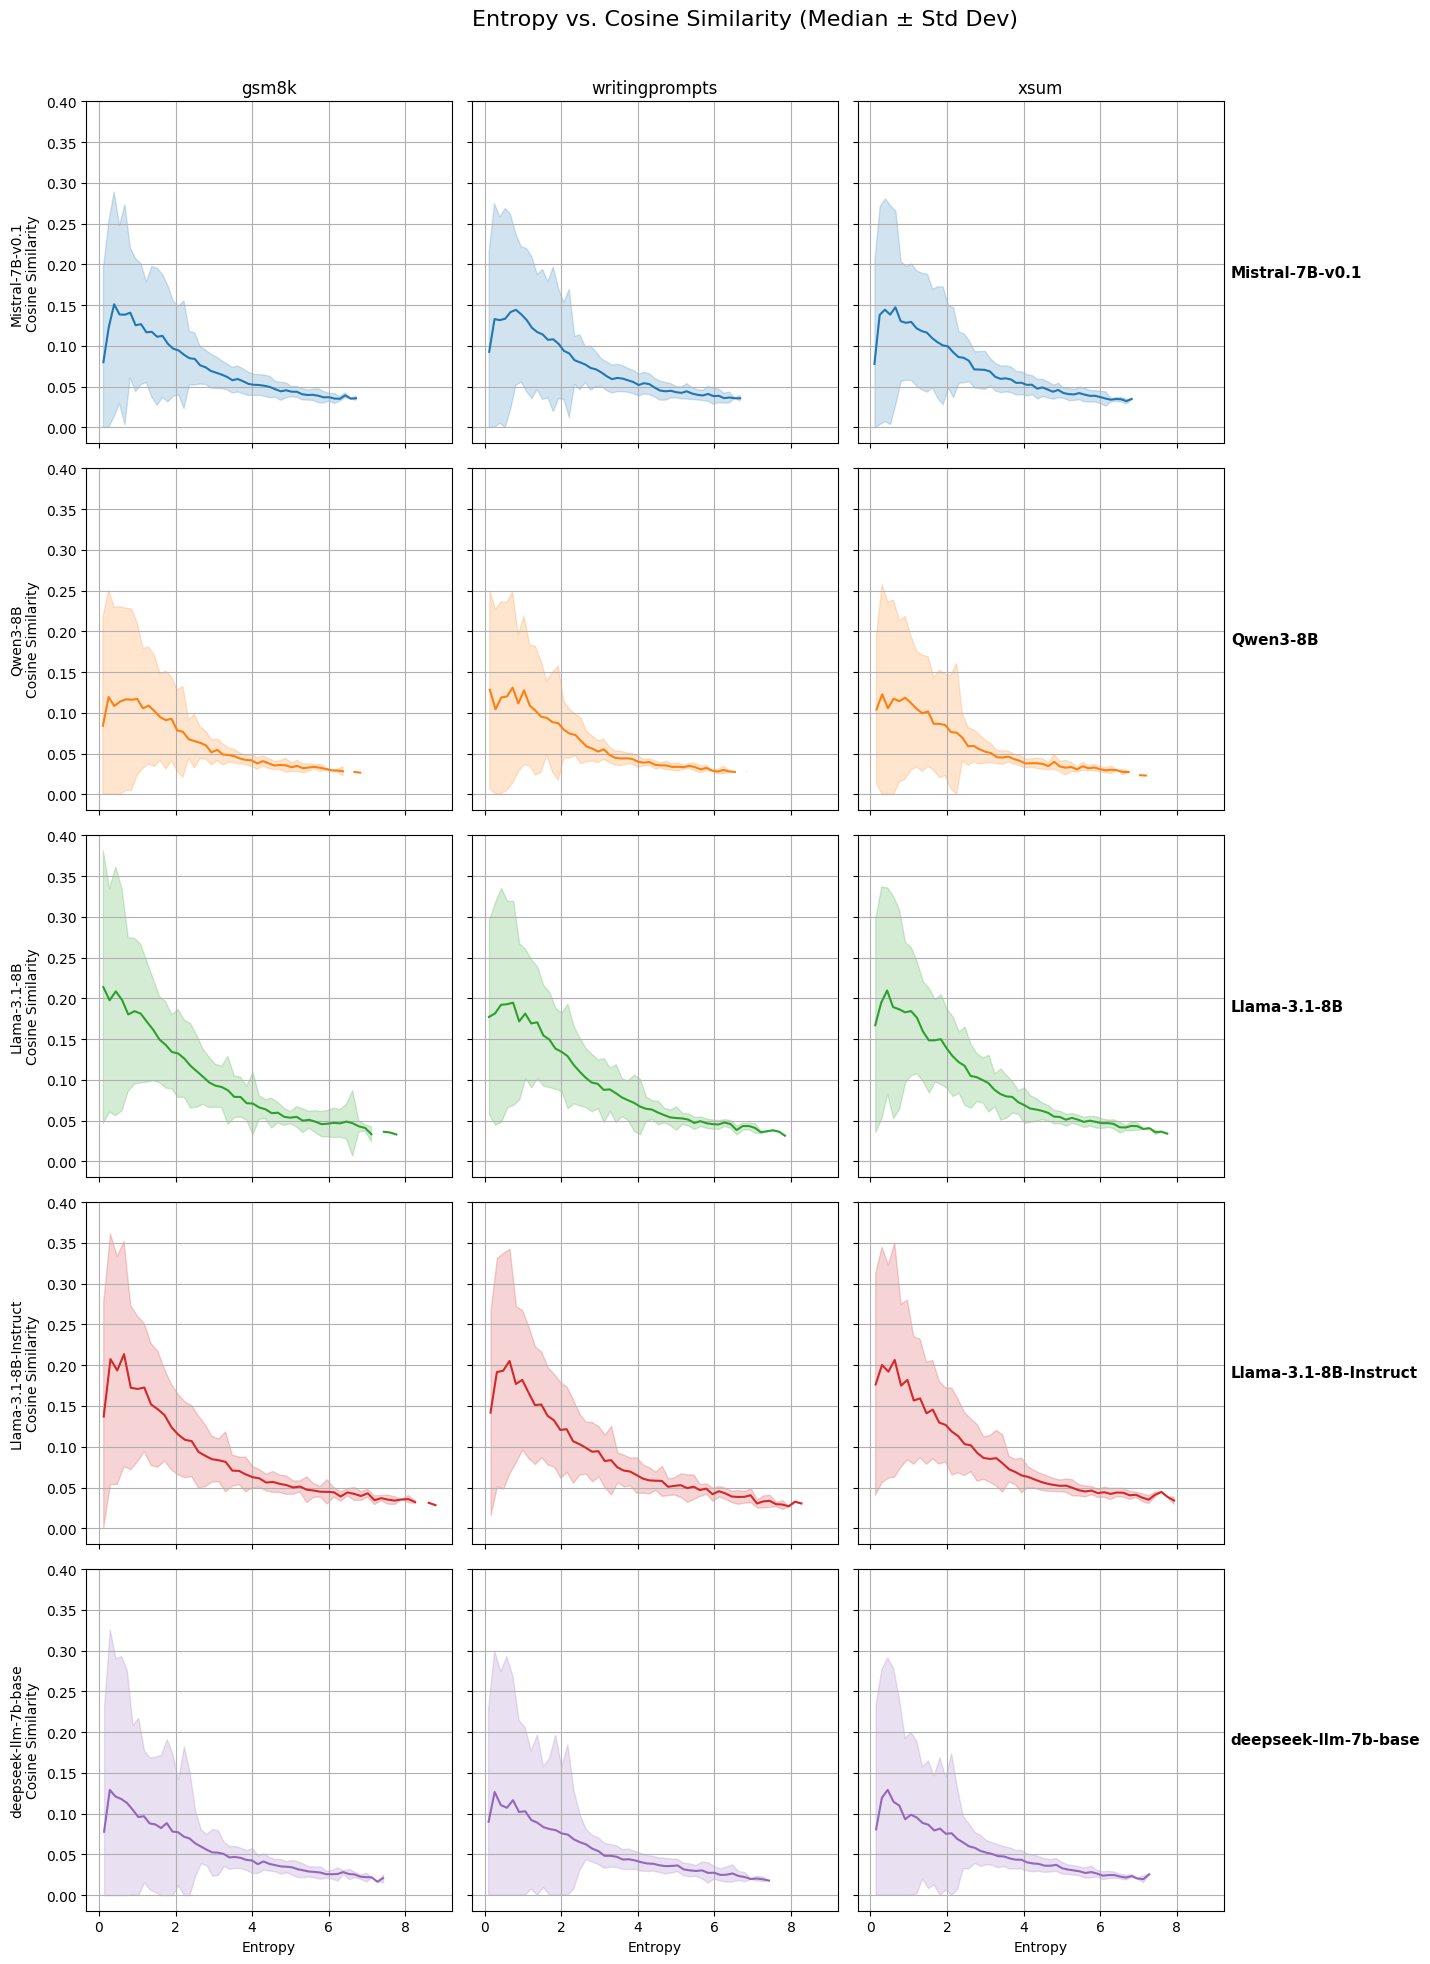

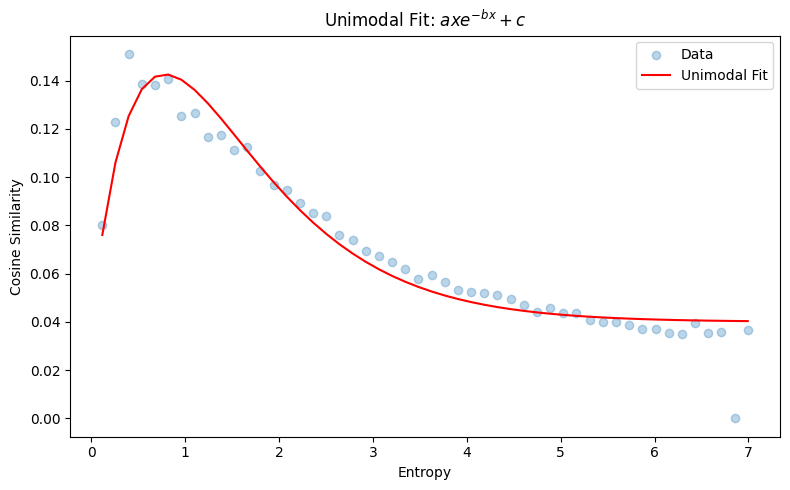

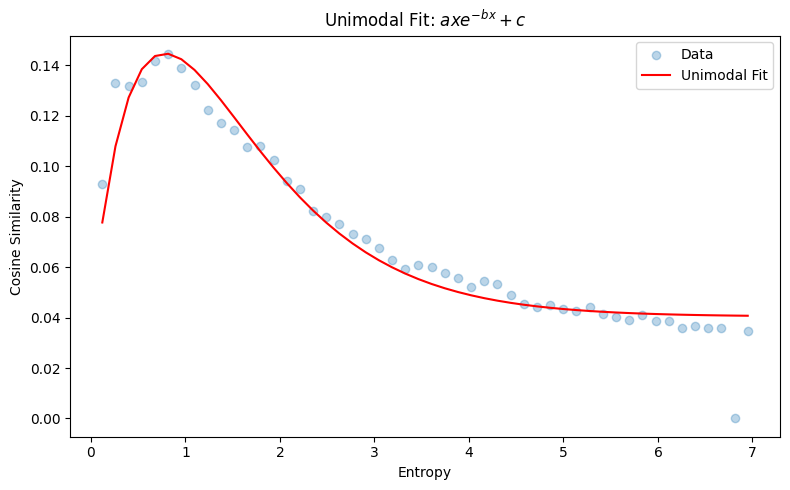

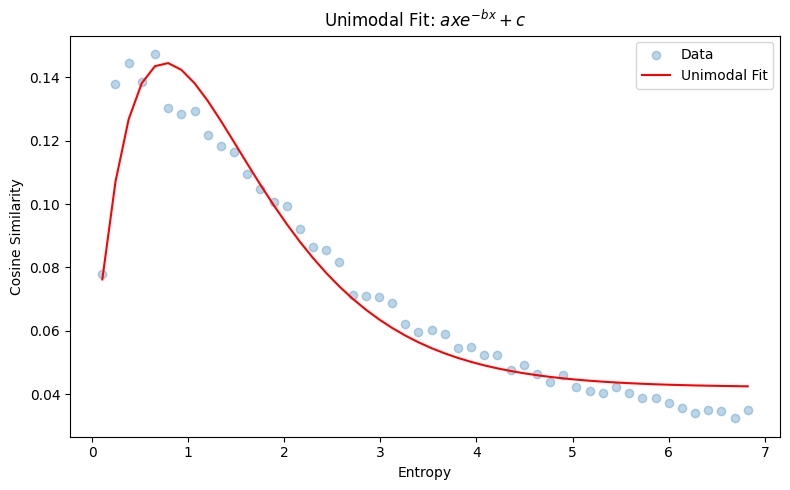

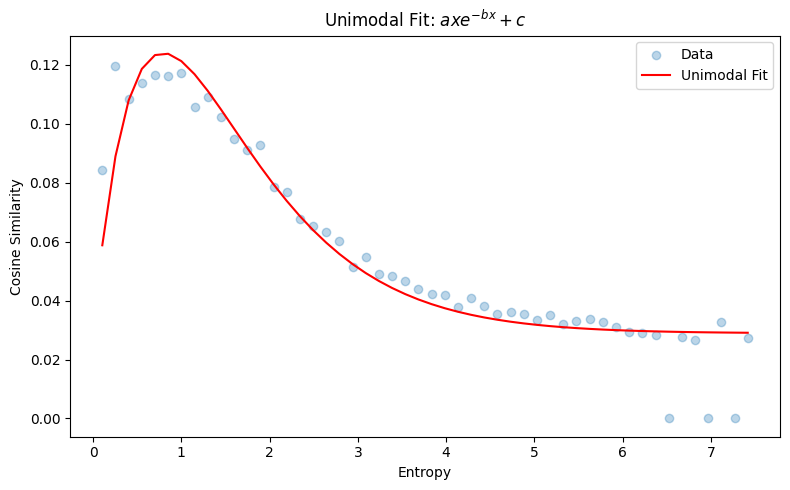

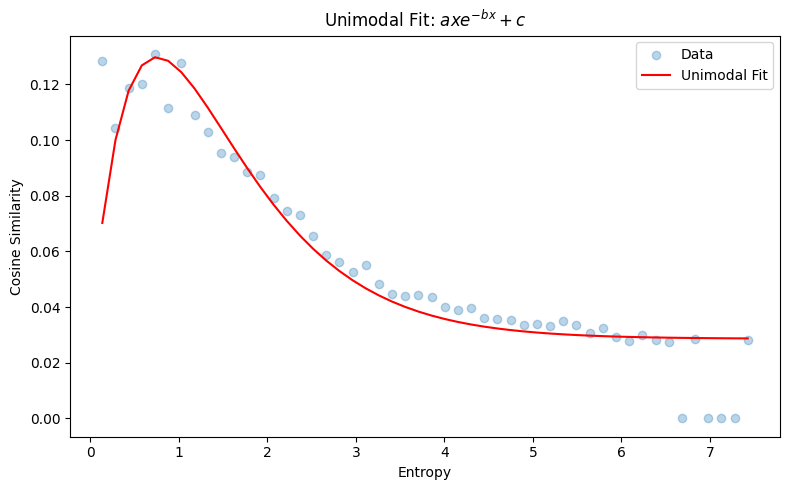

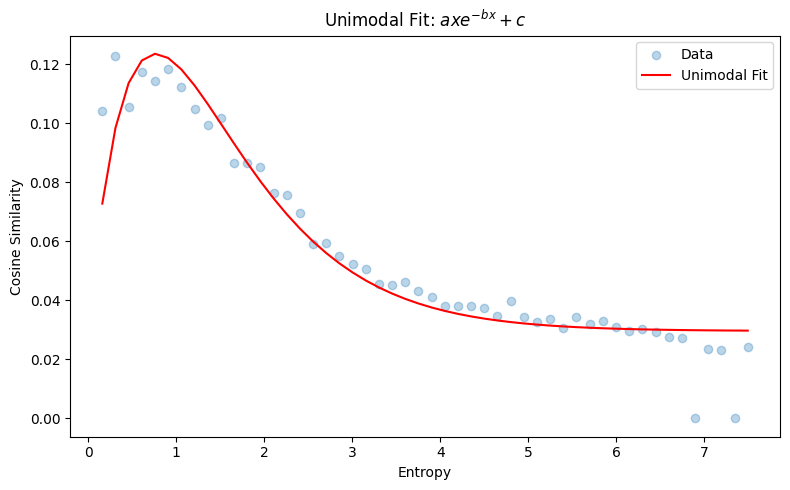

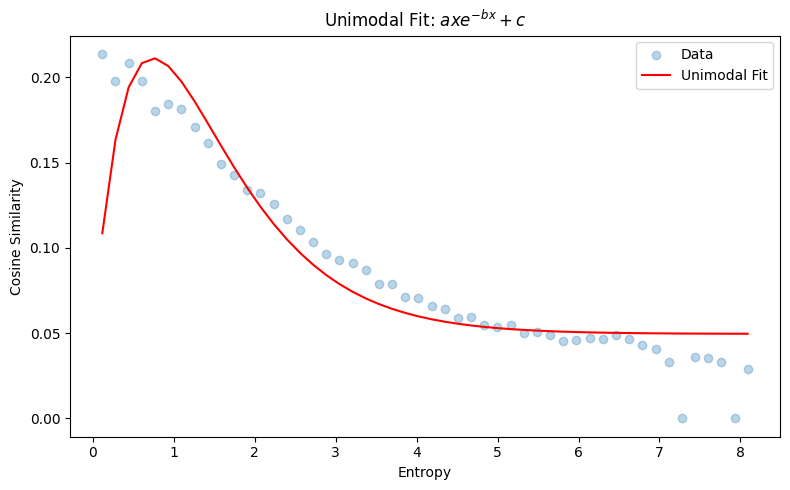

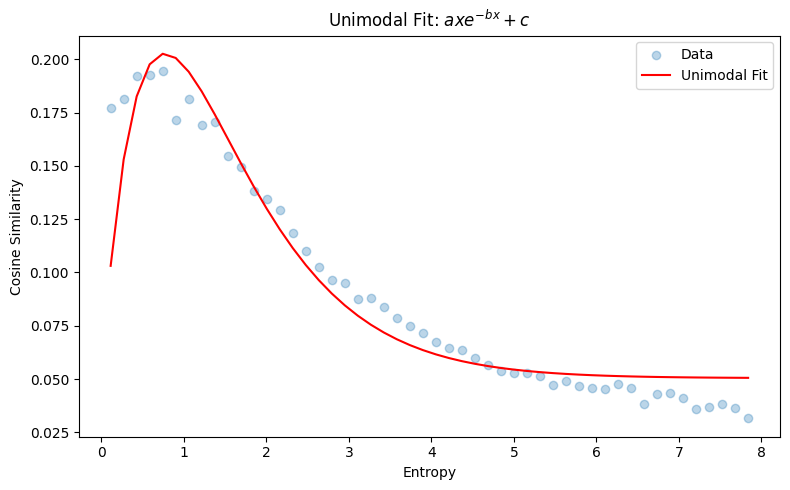

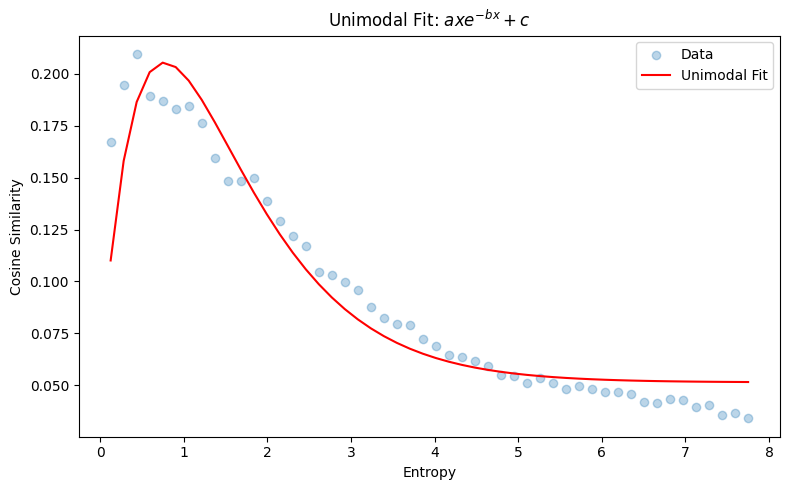

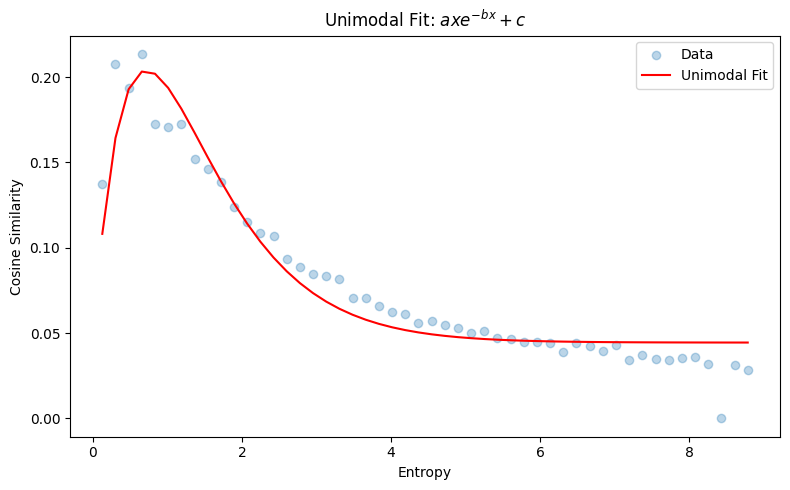

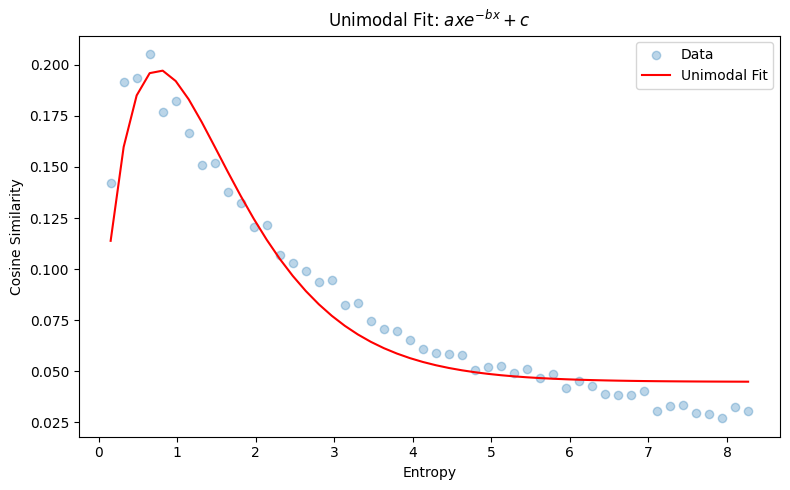

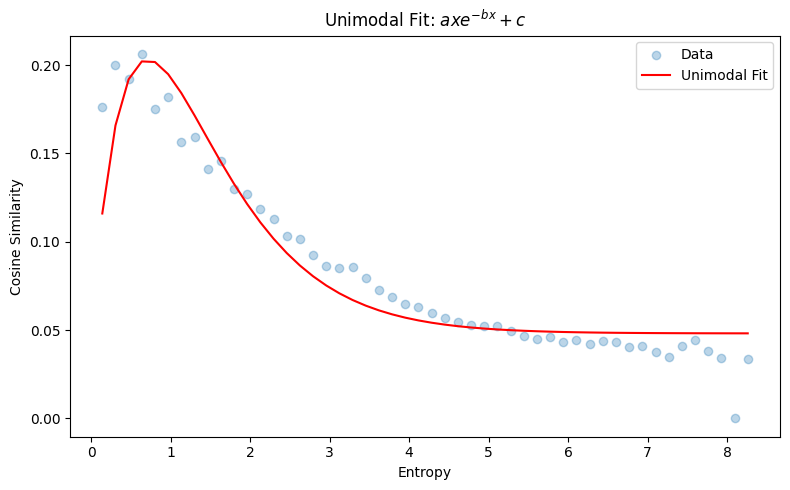

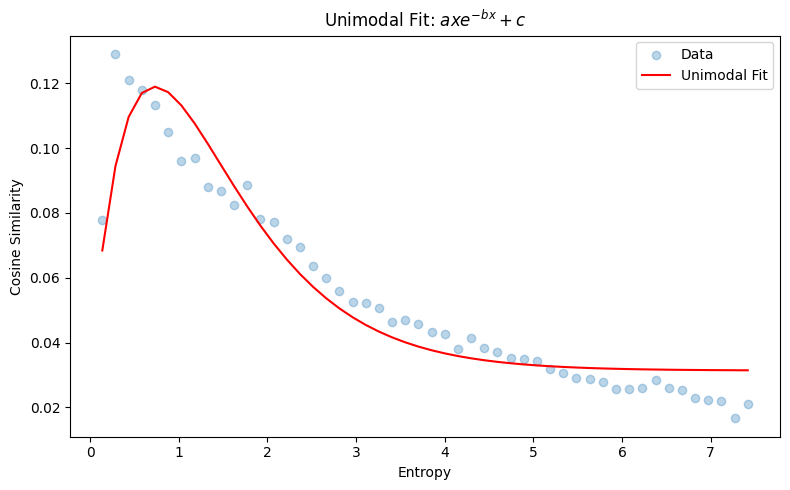

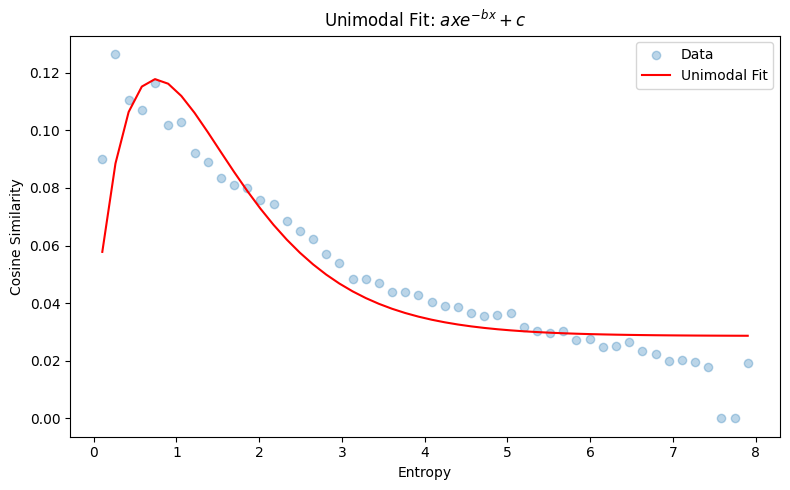

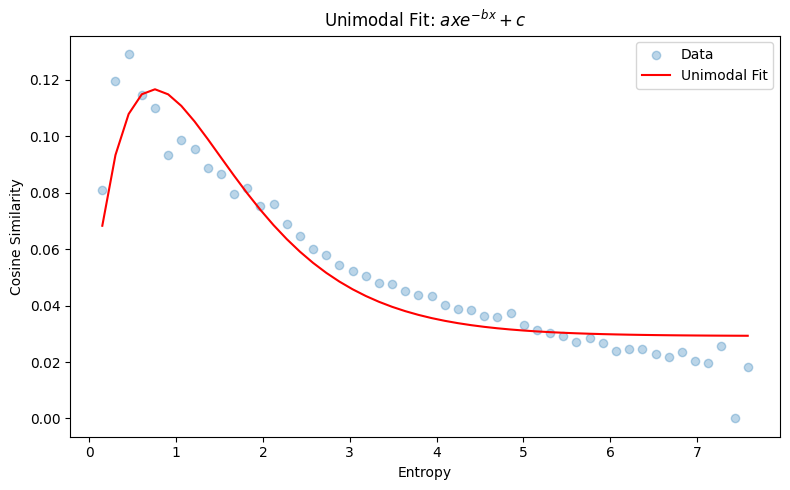

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic, pearsonr, spearmanr
import matplotlib.cm as cm
import matplotlib.colors as mcolors

global_model_data_points = {}
global_dataset_data_points = {}
global_model_data_median = {}
global_dataset_data_median = {}

def process_and_collect(experiment_results, remove_zero_one_points, dataset_name, model_name):
    entropies = []
    cosines = []

    for prompt_result in experiment_results["data"]:
        entropies.extend(prompt_result["entropies"])
        cosines.extend(prompt_result["cosines"])

    entropies = np.array(entropies, dtype=float)
    cosines = np.array(cosines, dtype=float)




    if remove_zero_one_points:
        mask = ~((entropies == 0) & (cosines == 1))
        entropies = entropies[mask]
        cosines = cosines[mask]

    # Add to global 
    global_model_data_points[model_name] = global_model_data_points.get(model_name, {"entropies" : np.array([], dtype=float), "cosines" : np.array([], dtype=float)})
    global_model_data_points[model_name]["entropies"] = np.concatenate([global_model_data_points[model_name]["entropies"] , entropies])
    global_model_data_points[model_name]["cosines"] = np.concatenate([global_model_data_points[model_name]["cosines"] , cosines])

    global_dataset_data_points[dataset_name] = global_dataset_data_points.get(dataset_name, {"entropies" : np.array([], dtype=float), "cosines" : np.array([], dtype=float)})
    global_dataset_data_points[dataset_name]["entropies"] = np.concatenate([global_dataset_data_points[dataset_name]["entropies"] , entropies])
    global_dataset_data_points[dataset_name]["cosines"] = np.concatenate([global_dataset_data_points[dataset_name]["cosines"] , cosines])

    # Stats
    r, p = pearsonr(entropies, cosines)
    rho, p2 = spearmanr(entropies, cosines)
    print(f"  Pearson r={r:.3f}, Spearman rho={rho:.3f}")
    

    # Binning
    num_bins = 50
    bin_medians, bin_edges, _ = binned_statistic(entropies, cosines, statistic='median', bins=num_bins)
    bin_indices = np.digitize(entropies, bin_edges)
    bin_std = np.zeros(num_bins)
    for i in range(1, num_bins + 1):
        bin_values = cosines[bin_indices == i]
        if len(bin_values) > 0:
            bin_std[i-1] = np.std(bin_values)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    #TODO also try mean instead of median


    mask = np.isfinite(bin_centers) & np.isfinite(bin_medians)
    cleaned_bin_centers = bin_centers[mask]
    cleaned_bin_medians = bin_medians[mask]
    # Add to global 
    global_model_data_median[model_name] = global_model_data_median.get(model_name, {"entropies" : np.array([], dtype=float), "cosines" : np.array([], dtype=float)})
    global_model_data_median[model_name]["entropies"] = np.concatenate([global_model_data_median[model_name]["entropies"] , cleaned_bin_centers])
    global_model_data_median[model_name]["cosines"] = np.concatenate([global_model_data_median[model_name]["cosines"] , cleaned_bin_medians])

    global_dataset_data_median[dataset_name] = global_dataset_data_median.get(dataset_name, {"entropies" : np.array([], dtype=float), "cosines" : np.array([], dtype=float)})
    global_dataset_data_median[dataset_name]["entropies"] = np.concatenate([global_dataset_data_median[dataset_name]["entropies"] , cleaned_bin_centers])
    global_dataset_data_median[dataset_name]["cosines"] = np.concatenate([global_dataset_data_median[dataset_name]["cosines"] , cleaned_bin_medians])


    #return bin_centers, bin_medians, bin_std
    return bin_centers, bin_medians, bin_std, r, p, rho, p2



#root_dir = "results/" #TODO use this in .py
root_dir = "./../results/correlation_exp/" #TODO use this in .ipynb
results = load_results(root_dir)

# Collect datasets/models
datasets = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
models = set()
for d in datasets:
    d_path = os.path.join(root_dir, d)
    for m in os.listdir(d_path):
        if os.path.isdir(os.path.join(d_path, m)):
            models.add(m)
models = list(models)

# Assign fixed color per model
model_colors = dict(zip(models, cm.get_cmap("tab10").colors[:len(models)]))

fig, axes = plt.subplots(len(models), len(datasets), figsize=(5 * len(datasets), 4 * len(models)), sharex=True, sharey=True)
if len(datasets) == 1 and len(models) == 1:
    axes = np.array([[axes]])
elif len(models) == 1:
    axes = axes[np.newaxis, :]
elif len(datasets) == 1:
    axes = axes[:, np.newaxis]


import pandas as pd

stats_rows = []



for i, model_name in enumerate(models):
    for j, dataset_name in enumerate(datasets):
        ax = axes[i][j]
        model_path = os.path.join(root_dir, dataset_name, model_name)
        if not os.path.isdir(model_path):
            ax.set_visible(False)
            continue

        print(f"Model: {model_name} Dataset: {dataset_name}")
        experiment_results = results[dataset_name][model_name]
        bin_centers, bin_medians, bin_std, r, p, rho, p2 = process_and_collect(experiment_results, True, dataset_name, model_name)
        
        # Unimodal model fitting
        bin_centers2 = np.nan_to_num(bin_centers, nan=0.0)
        bin_medians2 = np.nan_to_num(bin_medians, nan=0.0)
        # TODO dont replace nan with 0, is there a way to remove nan?
        unimodal_fitting(bin_centers2, bin_medians2)

        # Add row to stats table
        stats_rows.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Pearson r": round(r, 4),
            "Pearson p": round(p, 4),
            "Spearman r": round(rho, 4),
            "Spearman p": round(p2, 4)
        })
        lower = np.clip(bin_medians - bin_std, 0, None)
        upper = bin_medians + bin_std
        color = model_colors[model_name]

        ax.plot(bin_centers, bin_medians, label=model_name, color=color)
        ax.fill_between(bin_centers, lower, upper, alpha=0.2, color=color)

        # Left-side model name
        if j == 0:
            ax.set_ylabel(f"{model_name}\nCosine Similarity", fontsize=10)

        # Right-side model name again for clarity (optional)
        if j == len(datasets) - 1:
            ax.text(1.02, 0.5, model_name,
                    transform=ax.transAxes,
                    fontsize=11, fontweight='bold',
                    va='center', ha='left')

        if i == len(models) - 1:
            ax.set_xlabel("Entropy")
        if i == 0:
            ax.set_title(dataset_name)

        ax.grid(True)

# Shared legend (optional, add outside grid if needed)
# fig.legend(models, loc="upper right")

fig.suptitle("Entropy vs. Cosine Similarity (Median ± Std Dev)", fontsize=16)
fig.tight_layout(rect=[0, 0, 0.96, 0.97])
fig.savefig("correlation.png", dpi=300, bbox_inches="tight")

fig.show()


# Build stats table
stats_df = pd.DataFrame(stats_rows)
stats_df.set_index(["Model", "Dataset"], inplace=True)

# Print or save
print("\n=== Correlation Statistics Table ===")
print(stats_df.to_string())

# Optional: save to CSV
stats_df.to_csv("correlation_stats.csv")

with open("correlation_stats.tex", "w") as f:
    f.write(stats_df.to_latex(multicolumn=True, multirow=True, float_format="%.2f"))



models
Fitted params: a=0.7392, b=1.7032, c=0.0703
R² = 0.354
Fitted params: a=0.6772, b=1.5905, c=0.0739
R² = 0.384
Fitted params: a=0.5775, b=1.6839, c=0.0453
R² = 0.202


/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Fitted params: a=0.5260, b=1.6133, c=0.0573
R² = 0.268
Fitted params: a=0.5001, b=1.7385, c=0.0538
R² = 0.144


/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


datasets
Fitted params: a=0.5723, b=1.6451, c=0.0613
R² = 0.255
Fitted params: a=0.5843, b=1.6470, c=0.0614
R² = 0.250


/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Fitted params: a=0.5625, b=1.5893, c=0.0596
R² = 0.254


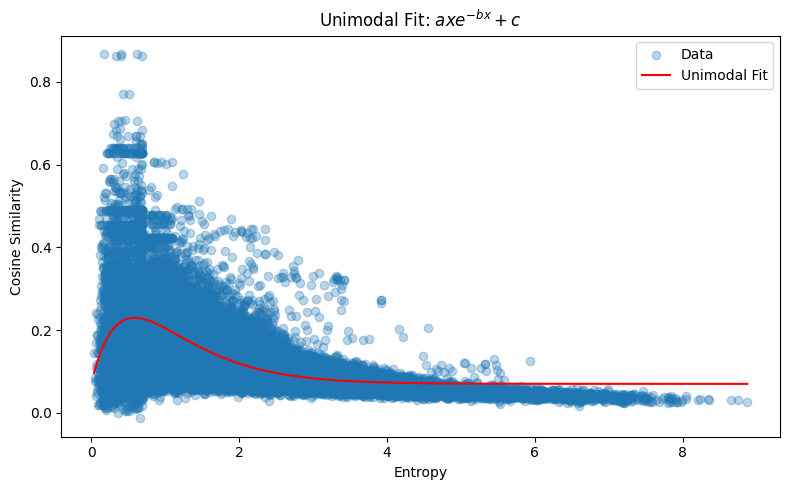

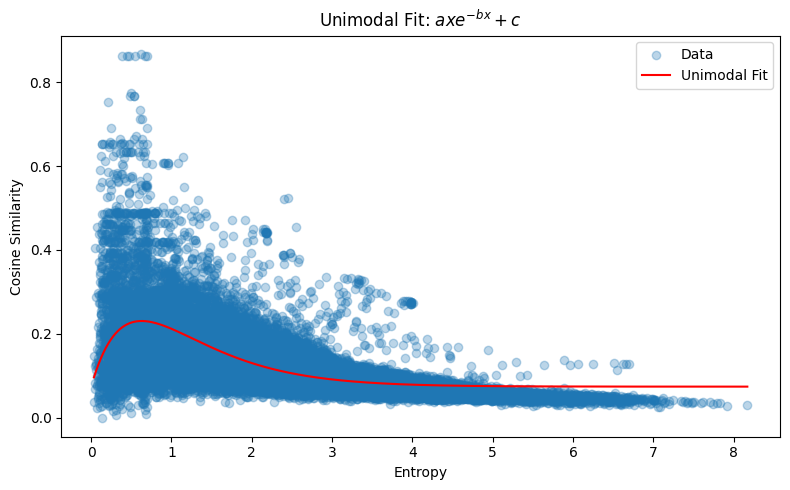

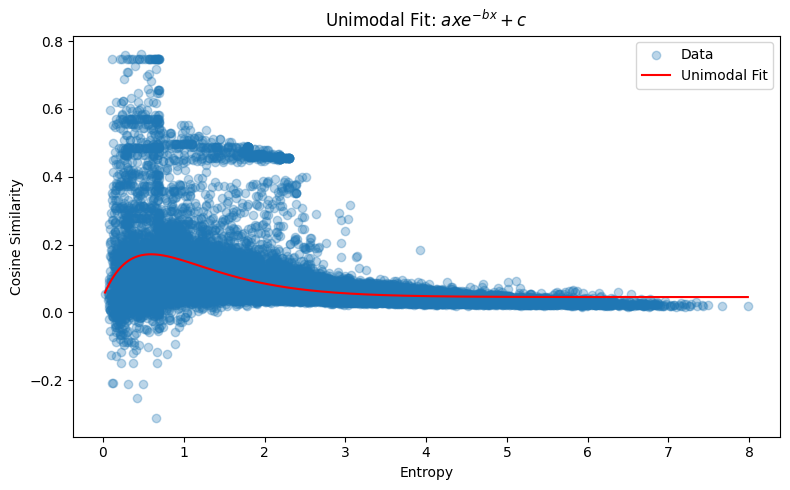

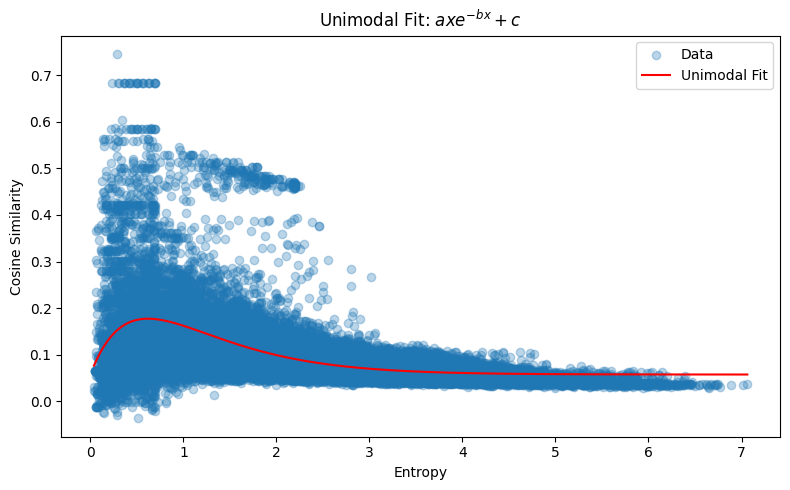

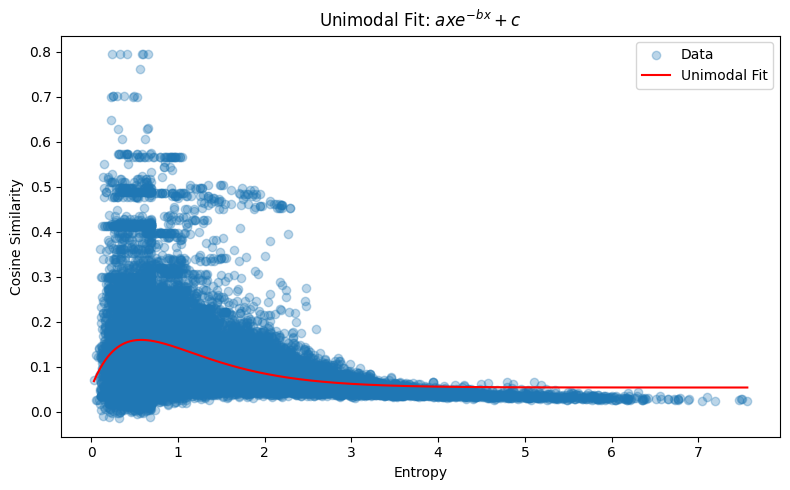

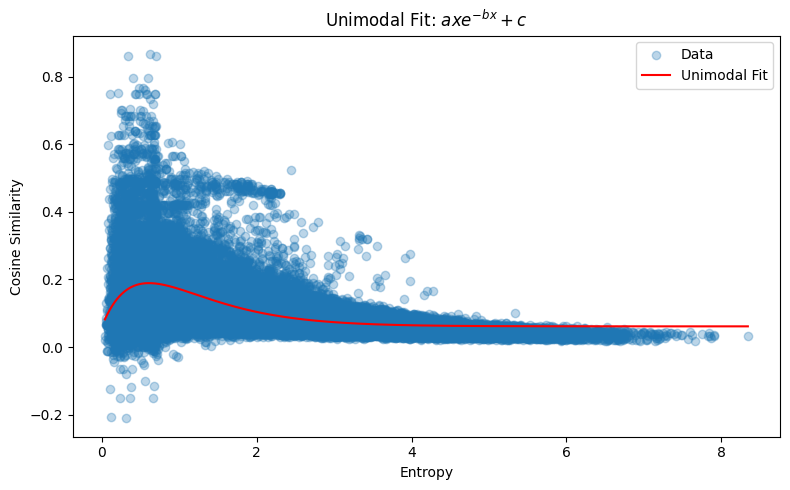

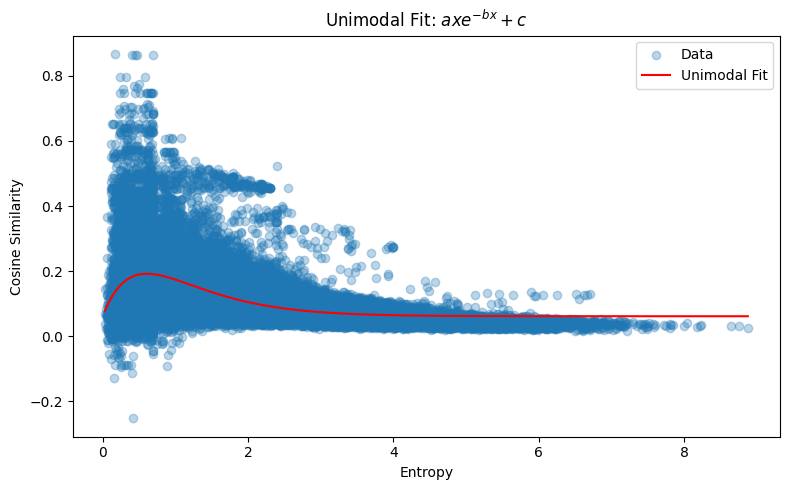

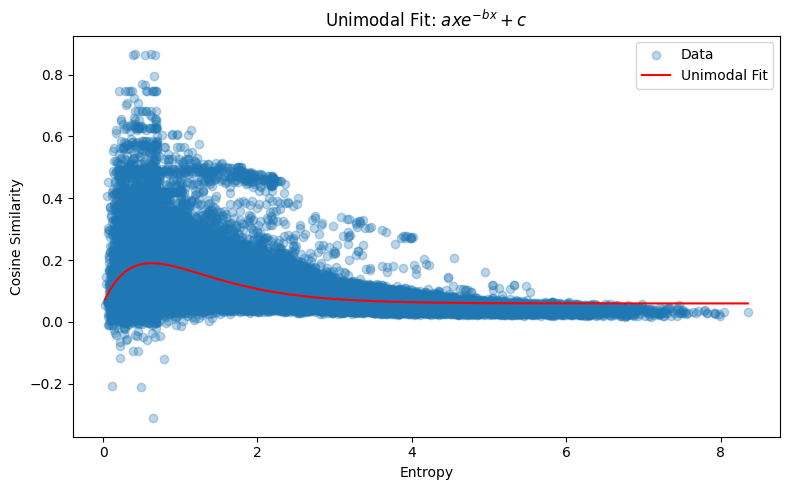

In [33]:
print("models")
unimodal_fitting(global_model_data_points["Llama-3.1-8B-Instruct"]["entropies"], global_model_data_points["Llama-3.1-8B-Instruct"]["cosines"])
unimodal_fitting(global_model_data_points["Llama-3.1-8B"]["entropies"], global_model_data_points["Llama-3.1-8B"]["cosines"])
unimodal_fitting(global_model_data_points["deepseek-llm-7b-base"]["entropies"], global_model_data_points["deepseek-llm-7b-base"]["cosines"])
unimodal_fitting(global_model_data_points["Mistral-7B-v0.1"]["entropies"], global_model_data_points["Mistral-7B-v0.1"]["cosines"])
unimodal_fitting(global_model_data_points["Qwen3-8B"]["entropies"], global_model_data_points["Qwen3-8B"]["cosines"])
print("datasets")
unimodal_fitting(global_dataset_data_points["xsum"]["entropies"], global_dataset_data_points["xsum"]["cosines"])
unimodal_fitting(global_dataset_data_points["gsm8k"]["entropies"], global_dataset_data_points["gsm8k"]["cosines"])
unimodal_fitting(global_dataset_data_points["writingprompts"]["entropies"], global_dataset_data_points["writingprompts"]["cosines"])


In [ ]:
 # look at the b values of models fitted on different models/datasets
 # zB alle models auf versch datasets bei gleichem llama, haben die das gleiche b value im model fitted
 # -> zB we run experiment on one dataset, and compute model, and can use that to show it on different datasets. So the trend persists between datasets
 # -> compare & contrast curves between different models

# zB transformation zwischen models die auf versch LLMs fitted wurden
# zB model fitten auf one model, one datasets. Daraus ableiten model für anderes dataset oder model (zB b value verkleinern etc)

# oder zB wir haben black box model und dataset, und fitten model, und aus dem a und b werten können wir ableiten, welches model/dataset genutzt wurde


# linear model fitten auf (y,z) y ist cosine, z ist expo model das wir gefittet haben
# Zeigen, dass es lineare abh. zwischen cosine und dem model gibt (basierend auf entropy)

models
Fitted params: a=0.5819, b=1.3860, c=0.0470
R² = 0.937
Fitted params: a=0.5597, b=1.3324, c=0.0519
R² = 0.908
Fitted params: a=0.3256, b=1.3778, c=0.0311
R² = 0.912
Fitted params: a=0.3623, b=1.3093, c=0.0422
R² = 0.963
Fitted params: a=0.3431, b=1.3637, c=0.0335
R² = 0.943


/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


datasets
Fitted params: a=0.4275, b=1.3602, c=0.0418
R² = 0.755
Fitted params: a=0.4340, b=1.3762, c=0.0417
R² = 0.753
Fitted params: a=0.4259, b=1.3450, c=0.0412
R² = 0.778


/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_46502/3575658831.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


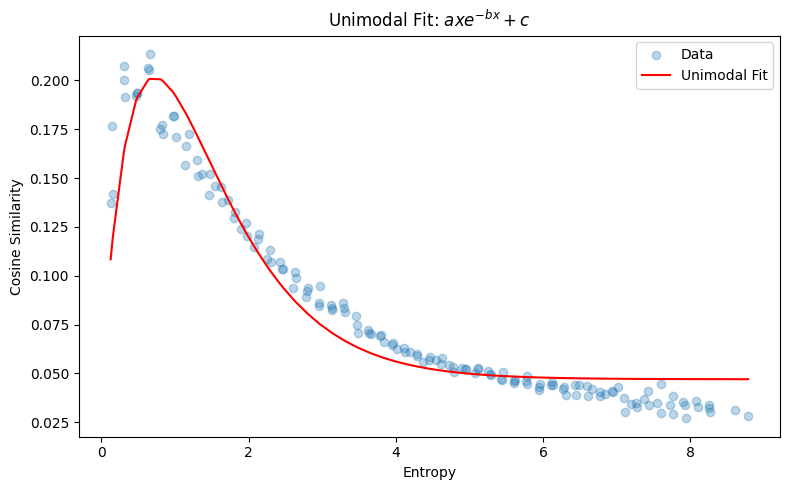

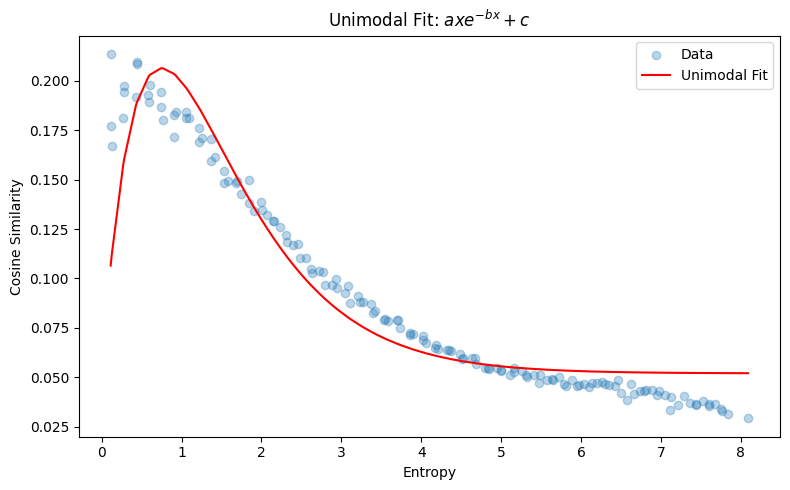

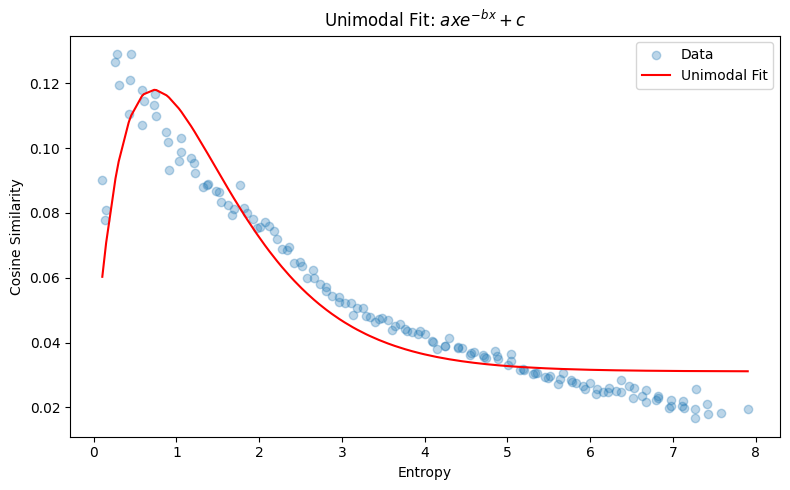

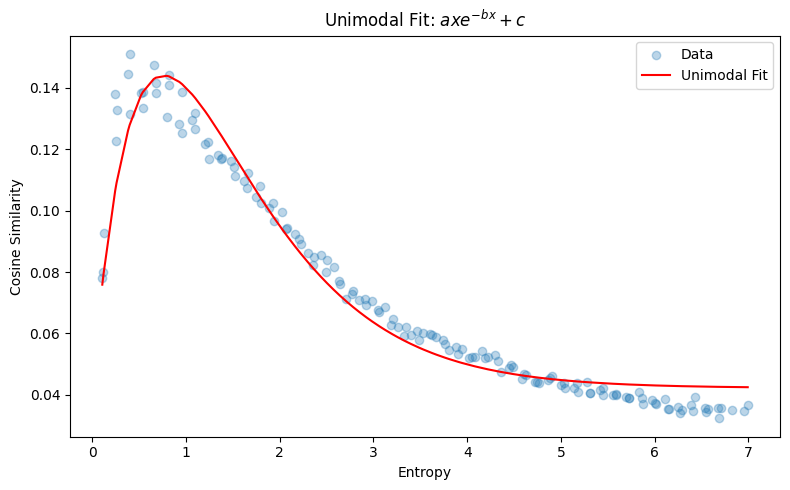

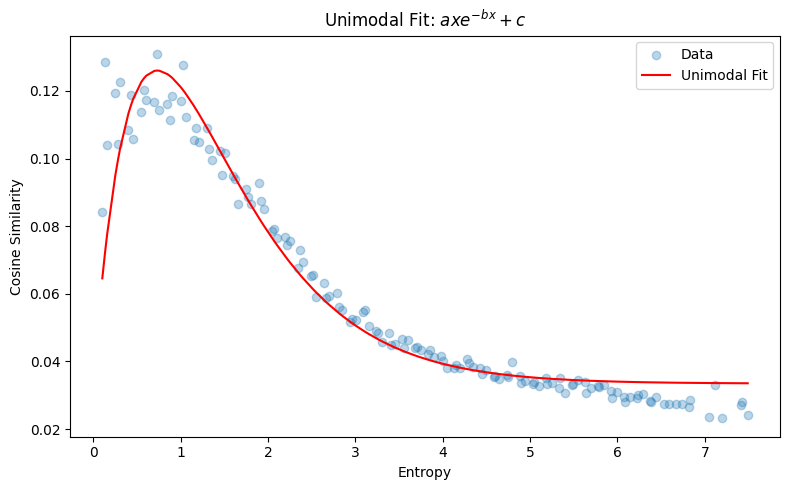

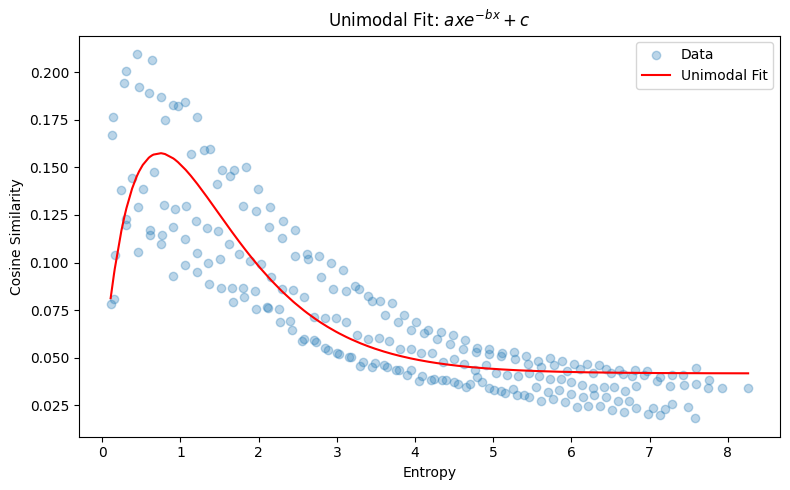

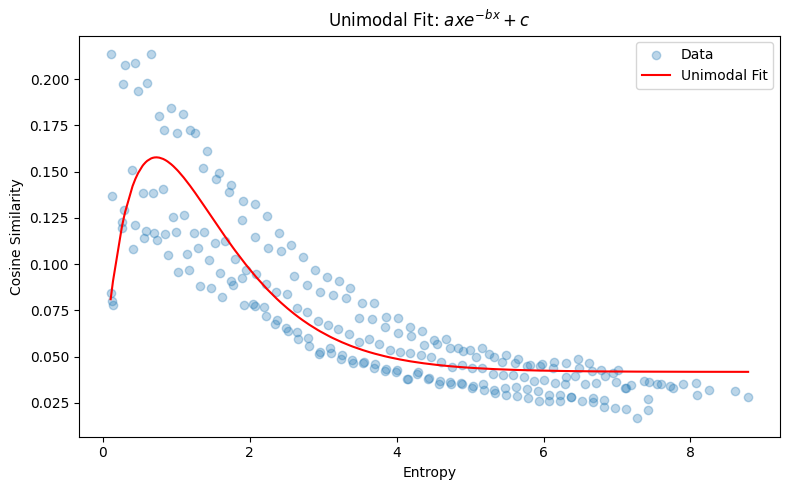

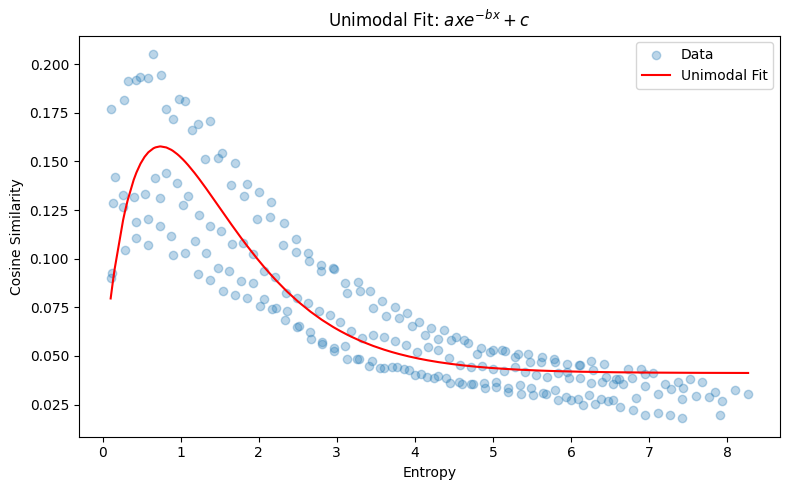

In [36]:

print("models")
unimodal_fitting(global_model_data_median["Llama-3.1-8B-Instruct"]["entropies"], global_model_data_median["Llama-3.1-8B-Instruct"]["cosines"])
unimodal_fitting(global_model_data_median["Llama-3.1-8B"]["entropies"], global_model_data_median["Llama-3.1-8B"]["cosines"])
unimodal_fitting(global_model_data_median["deepseek-llm-7b-base"]["entropies"], global_model_data_median["deepseek-llm-7b-base"]["cosines"])
unimodal_fitting(global_model_data_median["Mistral-7B-v0.1"]["entropies"], global_model_data_median["Mistral-7B-v0.1"]["cosines"])
unimodal_fitting(global_model_data_median["Qwen3-8B"]["entropies"], global_model_data_median["Qwen3-8B"]["cosines"])
print("datasets")
unimodal_fitting(global_dataset_data_median["xsum"]["entropies"], global_dataset_data_median["xsum"]["cosines"])
unimodal_fitting(global_dataset_data_median["gsm8k"]["entropies"], global_dataset_data_median["gsm8k"]["cosines"])
unimodal_fitting(global_dataset_data_median["writingprompts"]["entropies"], global_dataset_data_median["writingprompts"]["cosines"])


In [2]:
llama2_cot ={
    "samples": 1319,
    "accuracy": "89 / 879",
    "average_entropy": 0.07018199053001406,
    "average_entropy_correct_samples": 0.028646335919984445,
    "average_entropy_incorrect_samples": 0.07486132377089082,
    "average_cosine": 0.8788563430796879,
    "average_cosine_correct": 0.9378845214843752,
    "average_cosine_incorrect": 0.8722063331075143,
    "average_tokens_used": 145.09173616376043,
    "average_latency": 34.18762648855763,
    "average_au": 0.1821125720134826,
    "average_eu": 0.042365629106374154,
    "average_au_correct": 0.06373734492041198,
    "average_eu_correct": 0.04157591401860955,
    "average_au_incorrect": 0.19544851531890445,
    "average_eu_incorrect": 0.04245459700866663
}
llama2_cod = {
    "samples": 1319,
    "accuracy": "44 / 778",
    "average_entropy": 0.11003415573426623,
    "average_entropy_correct_samples": 0.0538767308505349,
    "average_entropy_incorrect_samples": 0.11340054087716021,
    "average_cosine": 0.8087421085691935,
    "average_cosine_correct": 0.8905043862082742,
    "average_cosine_incorrect": 0.8038408276208017,
    "average_tokens_used": 78.13722517058378,
    "average_latency": 15.859494245621722,
    "average_au": 0.3473841752891663,
    "average_eu": 0.04469751632426387,
    "average_au_correct": 0.17086958451704545,
    "average_eu_correct": 0.04318327470259233,
    "average_au_incorrect": 0.35796543141174575,
    "average_eu_incorrect": 0.04478828830158477
}
llama2_base = {
    "samples": 1319,
    "accuracy": "38 / 1045",
    "average_entropy": 0.7214619920571314,
    "average_entropy_correct_samples": 0.677209596679449,
    "average_entropy_incorrect_samples": 0.7231318937694967,
    "average_cosine": 0.15278884383599226,
    "average_cosine_correct": 0.16511174252158717,
    "average_cosine_incorrect": 0.1523238287912528,
    "average_tokens_used": 12.323730098559516,
    "average_latency": 1.632463357229862,
    "average_au": 2.7013667628629596,
    "average_eu": 0.060608265289125156,
    "average_au_correct": 2.531605503015351,
    "average_eu_correct": 0.061290674042283444,
    "average_au_incorrect": 2.707772848140228,
    "average_eu_incorrect": 0.06058251401542108
}

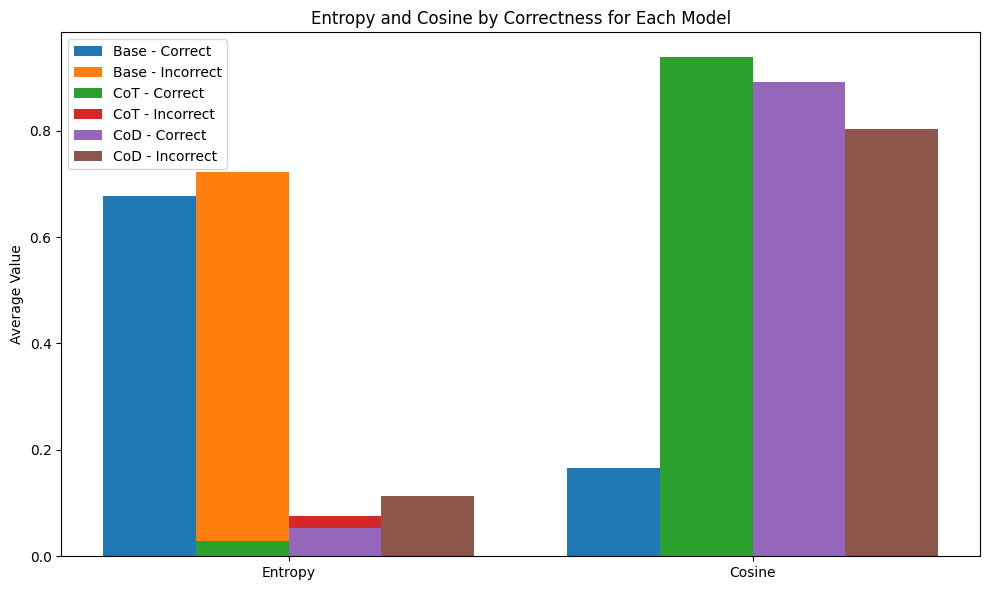

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for three models
# Replace these dictionaries with actual data per model
models = {
    "Base": llama2_base,
    "CoT": llama2_cot,
    "CoD": llama2_cod,
}

labels = ['Entropy', 'Cosine']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i, (model_name, data) in enumerate(models.items()):
    correct_vals = [data["average_entropy_correct_samples"], data["average_cosine_correct"]]
    incorrect_vals = [data["average_entropy_incorrect_samples"], data["average_cosine_incorrect"]]
    offset = (i - 1) * width
    ax.bar(x + offset - width/2, correct_vals, width, label=f'{model_name} - Correct')
    ax.bar(x + offset + width/2, incorrect_vals, width, label=f'{model_name} - Incorrect')

ax.set_ylabel('Average Value')
ax.set_title('Entropy and Cosine by Correctness for Each Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


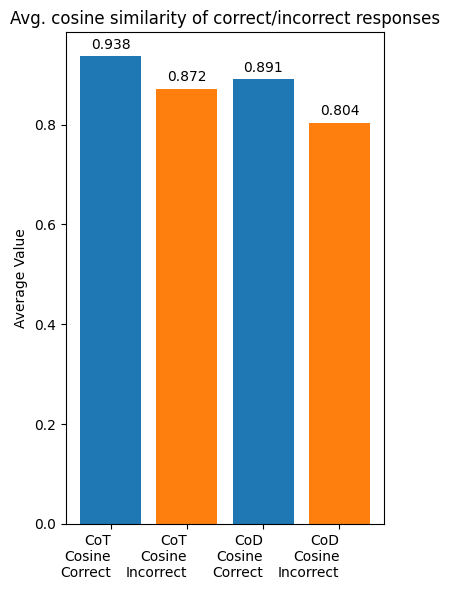

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these dictionaries with actual data per model
models = {
    #"Base": llama2_base,
    "CoT": llama2_cot,
    "CoD": llama2_cod,
}

labels = []
values = []
colors = []

for model_name, data in models.items():
    labels.extend([
        #f'{model_name}\nEntropy of\ncorrect samples',
        #f'{model_name}\nEntropy\nIncorrect',
        f'{model_name}\nCosine\nCorrect',
        f'{model_name}\nCosine\nIncorrect'
    ])
    values.extend([
        #data["average_entropy_correct_samples"],
        #data["average_entropy_incorrect_samples"],
        data["average_cosine_correct"],
        data["average_cosine_incorrect"]
    ])
    colors.extend(['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange'])

x = np.arange(len(values))

fig, ax = plt.subplots(figsize=(4, 6))
bars = ax.bar(x, values, color=colors)

ax.set_ylabel('Average Value')
ax.set_title('Avg. cosine similarity of correct/incorrect responses')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() /2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


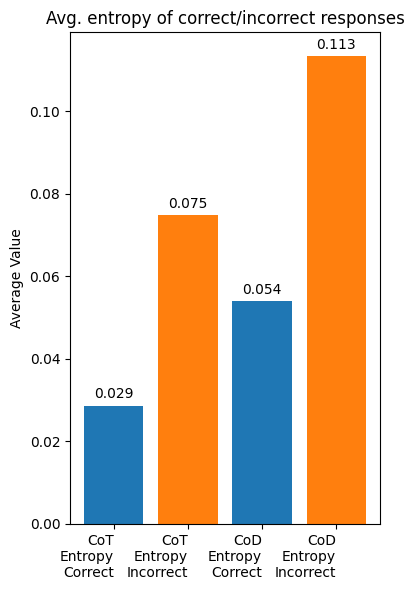

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these dictionaries with actual data per model
models = {
    #"Base": llama2_base,
    "CoT": llama2_cot,
    "CoD": llama2_cod,
}

labels = []
values = []
colors = []

for model_name, data in models.items():
    labels.extend([
        f'{model_name}\nEntropy\nCorrect',
        f'{model_name}\nEntropy\nIncorrect',
        #f'{model_name}\nCosine\nCorrect',
        #f'{model_name}\nCosine\nIncorrect'
    ])
    values.extend([
        data["average_entropy_correct_samples"],
        data["average_entropy_incorrect_samples"],
        #data["average_cosine_correct"],
        #data["average_cosine_incorrect"]
    ])
    colors.extend(['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange'])

x = np.arange(len(values))

fig, ax = plt.subplots(figsize=(4, 6))
bars = ax.bar(x, values, color=colors)

ax.set_ylabel('Average Value')
ax.set_title('Avg. entropy of correct/incorrect responses')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() /2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()